In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [3]:
df = pd.read_csv('NVDA.csv')
print("First few rows of the dataset:")
display(df.head())

# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'])

print("First few rows of the dataset:")
display(df.head())

First few rows of the dataset:


,Date,Adj Close,Close,High,Low,Open,Volume
0,28/11/2022,15.812541,15.827000,16.357000,15.725,16.025999,303741000
1,29/11/2022,15.624713,15.639000,15.932000,15.520,15.827000,298384000
2,30/11/2022,16.911863,16.923000,16.930000,15.597,15.697000,565298000
3,01/12/2022,17.123726,17.135000,17.264999,16.635,16.999001,470977000
4,02/12/2022,16.864895,16.875999,16.933001,16.445,16.659000,371389000


First few rows of the dataset:


C:\Users\Rushaan\AppData\Local\Temp\ipykernel_17312\128541.py:6: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Date'] = pd.to_datetime(df['Date'])


,Date,Adj Close,Close,High,Low,Open,Volume
0,2022-11-28,15.812541,15.827000,16.357000,15.725,16.025999,303741000
1,2022-11-29,15.624713,15.639000,15.932000,15.520,15.827000,298384000
2,2022-11-30,16.911863,16.923000,16.930000,15.597,15.697000,565298000
3,2022-12-01,17.123726,17.135000,17.264999,16.635,16.999001,470977000
4,2022-12-02,16.864895,16.875999,16.933001,16.445,16.659000,371389000


In [4]:
# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())

# Add derived features
# Calculate moving averages
df['MA_5'] = df['Close'].rolling(window=5).mean()
df['MA_20'] = df['Close'].rolling(window=20).mean()

# Calculate price momentum
df['Momentum_1d'] = df['Close'].pct_change(periods=1)
df['Momentum_5d'] = df['Close'].pct_change(periods=5)

# Calculate volatility (standard deviation over a window)
df['Volatility_5d'] = df['Close'].rolling(window=5).std()

# Calculate volume changes
df['Volume_Change'] = df['Volume'].pct_change()

# Calculate price direction (target variable - 1 if price goes up, 0 if it goes down)
df['Price_Direction'] = (df['Close'].shift(-1) > df['Close']).astype(int)

# Drop rows with NaN values (due to rolling calculations)
df.dropna(inplace=True)


Missing values in each column:
Date         0
Adj Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
dtype: int64


In [5]:
# 2. Feature Selection
# Select features
features = ['Open', 'High', 'Low', 'Close', 'Volume',
            'MA_5', 'MA_20', 'Momentum_1d', 'Momentum_5d',
            'Volatility_5d', 'Volume_Change']
X = df[features]
y = df['Price_Direction']

In [6]:
# 3. Data Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# 4. Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
# 5. Model Training - MLP Classifier
# Basic MLP
mlp = MLPClassifier(hidden_layer_sizes=(100, 50),
                    activation='relu',
                    solver='adam',
                    alpha=0.0001,
                    batch_size=32,
                    learning_rate='adaptive',
                    max_iter=500,
                    random_state=42,
                    early_stopping=True,
                    validation_fraction=0.1)

# Train the model
mlp.fit(X_train_scaled, y_train)

MLPClassifier(batch_size=32, early_stopping=True, hidden_layer_sizes=(100, 50),
              learning_rate='adaptive', max_iter=500, random_state=42)


Model Accuracy: 0.5670

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.26      0.36        46
           1       0.56      0.84      0.67        51

    accuracy                           0.57        97
   macro avg       0.58      0.55      0.52        97
weighted avg       0.58      0.57      0.53        97



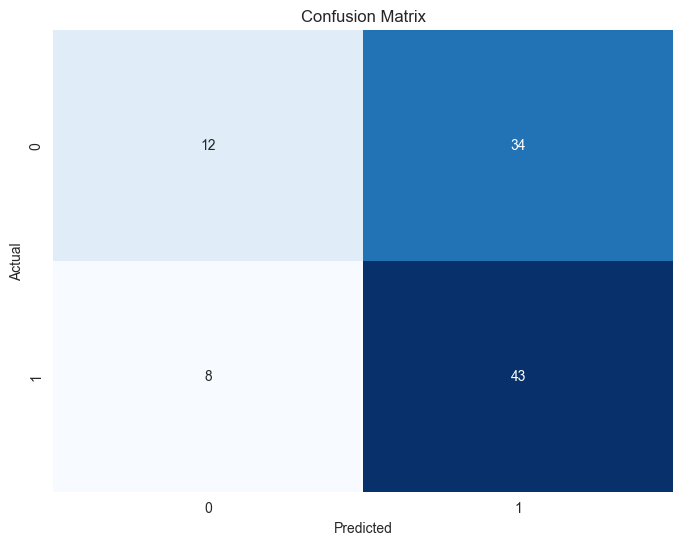

In [8]:
# 6. Model Evaluation
# Make predictions
y_pred = mlp.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy:.4f}")

# Display classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Display confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [9]:
# 7. Hyperparameter Tuning with GridSearchCV
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 25), (100, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive']
}

grid_search = GridSearchCV(
    estimator=MLPClassifier(max_iter=300, random_state=42, early_stopping=True),
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    scoring='accuracy'
)

grid_search.fit(X_train_scaled, y_train)

# Best parameters
print("\nBest Parameters:", grid_search.best_params_)
print("Best Accuracy Score:", grid_search.best_score_)


Best Parameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant'}
Best Accuracy Score: 0.5503875968992248


In [10]:
# 8. Final Model with Best Parameters
best_mlp = grid_search.best_estimator_
best_pred = best_mlp.predict(X_test_scaled)

print("\nFinal Model Accuracy:", accuracy_score(y_test, best_pred))
print("\nFinal Classification Report:")
print(classification_report(y_test, best_pred))


Final Model Accuracy: 0.5463917525773195

Final Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.33      0.41        46
           1       0.55      0.75      0.63        51

    accuracy                           0.55        97
   macro avg       0.54      0.54      0.52        97
weighted avg       0.54      0.55      0.53        97



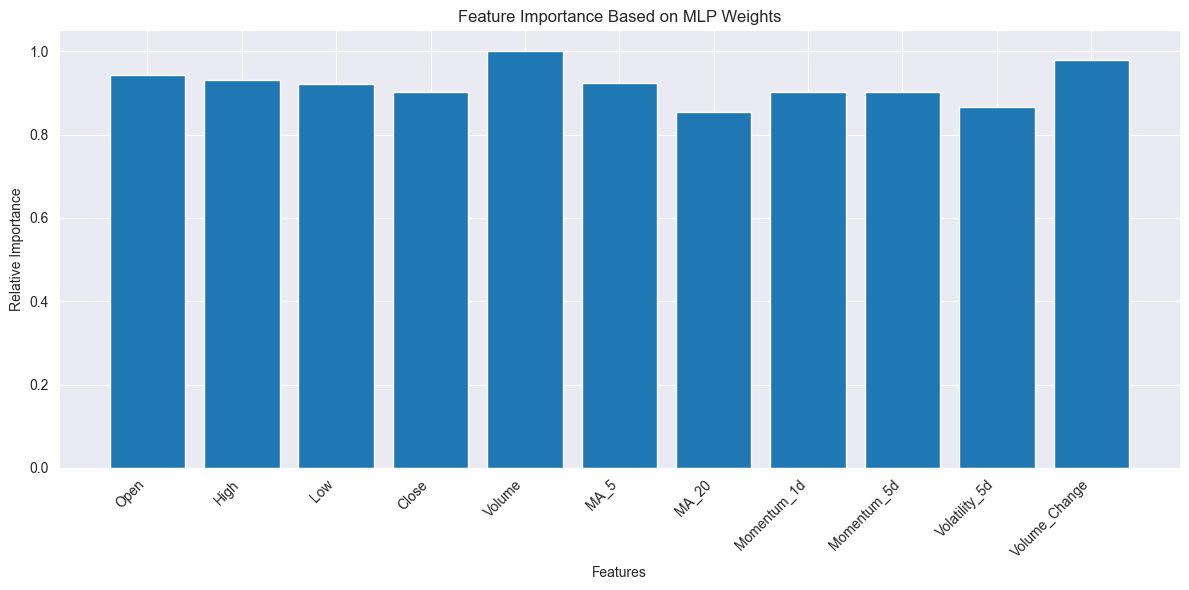

In [11]:
# 9. Feature Importance Analysis
plt.figure(figsize=(12, 6))
coefs = np.abs(best_mlp.coefs_[0])
feature_importance = np.sum(coefs, axis=1)
feature_importance = feature_importance / np.max(feature_importance)

# Plot feature importance
plt.bar(features, feature_importance)
plt.title('Feature Importance Based on MLP Weights')
plt.xlabel('Features')
plt.ylabel('Relative Importance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

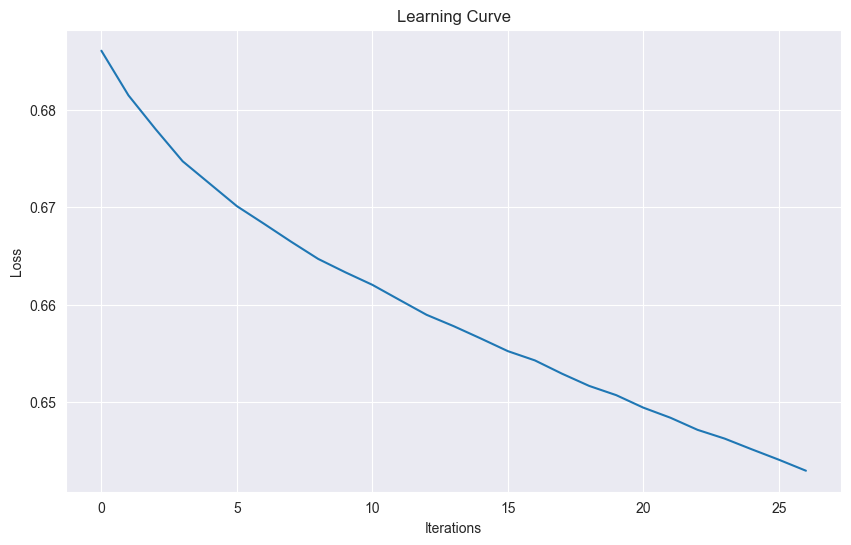

In [12]:
# 10. Visualize Learning Curve
plt.figure(figsize=(10, 6))
plt.plot(best_mlp.loss_curve_)
plt.title('Learning Curve')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

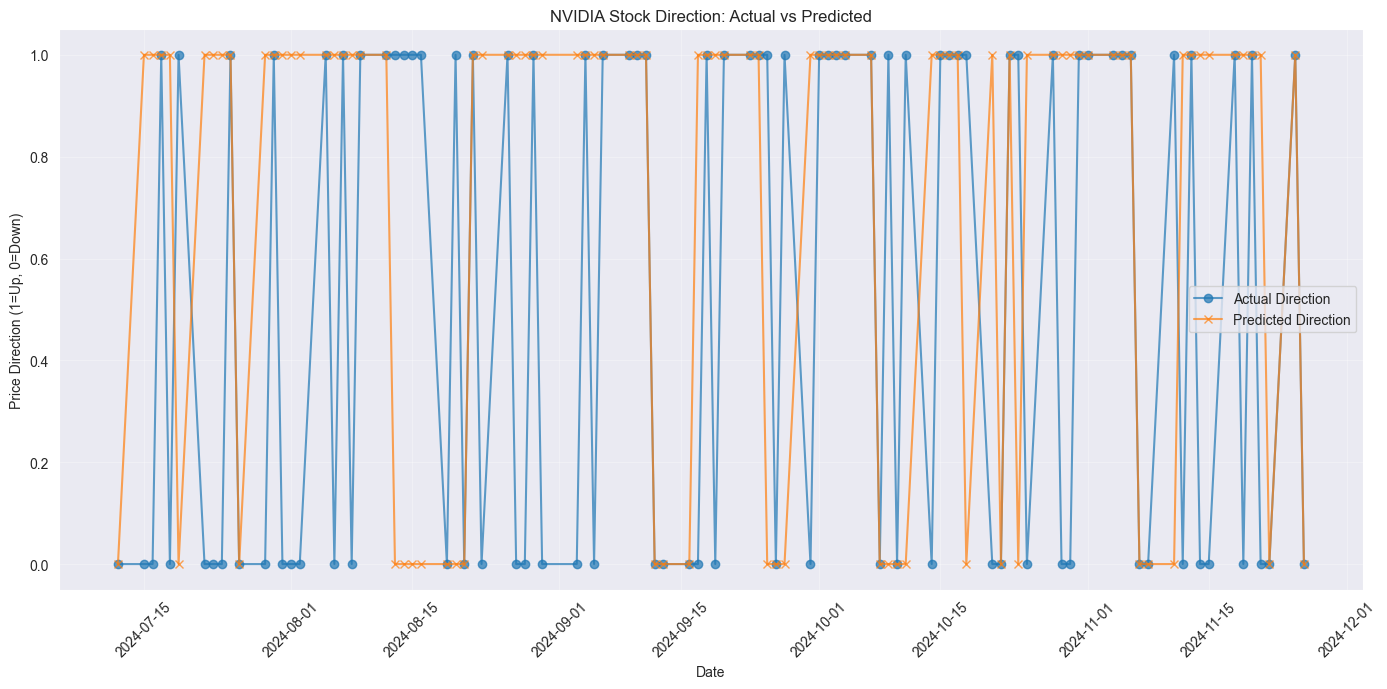

In [13]:
# 11. Model Performance Over Time
# Create a DataFrame with test data time indices and predictions
test_dates = df.iloc[len(X_train):].reset_index()['Date']
results_df = pd.DataFrame({
    'Date': test_dates,
    'Actual': y_test.values,
    'Predicted': best_pred
})

plt.figure(figsize=(14, 7))
plt.plot(results_df['Date'], results_df['Actual'], label='Actual Direction', marker='o', alpha=0.7)
plt.plot(results_df['Date'], results_df['Predicted'], label='Predicted Direction', marker='x', alpha=0.7)
plt.title('NVIDIA Stock Direction: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Price Direction (1=Up, 0=Down)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()